In [6]:
!pip install -U "tensorflow>=2.20"

   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
    --------------------------------------- 6.8/332.0 MB 37.9 MB/s eta 0:00:09
   - -------------------------------------- 15.7/332.0 MB 40.7 MB/s eta 0:00:08
   -- ------------------------------------- 24.4/332.0 MB 41.5 MB/s eta 0:00:08
   --- ------------------------------------ 32.8/332.0 MB 41.2 MB/s eta 0:00:08
   ---- ----------------------------------- 40.6/332.0 MB 40.5 MB/s eta 0:00:08
   ----- ---------------------------------- 48.5/332.0 MB 40.3 MB/s eta 0:00:08
   ------ --------------------------------- 54.0/332.0 MB 38.2 MB/s eta 0:00:08
   ------- -------------------------------- 61.6/332.0 MB 37.9 MB/s eta 0:00:08
   ------- -------------------------------- 64.2/332.0 MB 37.1 MB/s eta 0:00:08
   -------- ------------------------------- 67.6/332.0 MB 33.4 MB/s eta 0:00:08
   -------- ------------------------------- 72.4/332.0 MB 32.8 MB/s eta 0:00:08
   --------- ------------------------------ 75.2/3

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)


TensorFlow: 2.20.0


In [10]:
KAGGLE_TRAIN = r"C:\Users\ckoel\Downloads\train.csv.zip"
KAGGLE_TEST  = r"C:\Users\ckoel\Downloads\test.csv.zip"

if os.path.exists(KAGGLE_TRAIN):
    train_path, test_path = KAGGLE_TRAIN, KAGGLE_TEST
else:
    train_path, test_path = "train.csv", "test.csv"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

print("train_df:", train_df.shape)
print("test_df :", test_df.shape)
train_df.head()


train_df: (42000, 785)
test_df : (28000, 784)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
y = train_df["label"].to_numpy(dtype=np.int64)
X = train_df.drop(columns=["label"]).to_numpy(dtype=np.float32)

X_test = test_df.to_numpy(dtype=np.float32)

print("X:", X.shape, "y:", y.shape, "X_test:", X_test.shape)
print("Unique labels:", np.unique(y))
print("Pixel range (raw):", X.min(), "to", X.max())


X: (42000, 784) y: (42000,) X_test: (28000, 784)
Unique labels: [0 1 2 3 4 5 6 7 8 9]
Pixel range (raw): 0.0 to 255.0


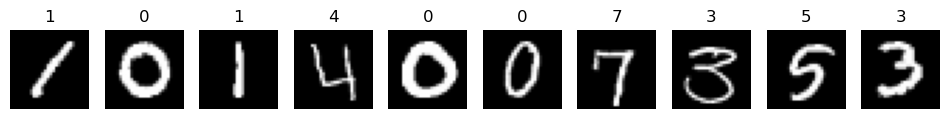

In [12]:
def show_images(X_flat, y=None, n=10):
    plt.figure(figsize=(12, 3))
    for i in range(n):
        img = X_flat[i].reshape(28, 28)
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        if y is not None:
            plt.title(str(y[i]))
    plt.show()

show_images(X, y, n=10)


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y
)

print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape, y_val.shape)


Train: (33600, 784) (33600,)
Val  : (8400, 784) (8400,)


In [14]:
X_train = X_train / 255.0
X_val   = X_val   / 255.0
X_test  = X_test  / 255.0

X_train = X_train.reshape(-1, 28, 28, 1)
X_val   = X_val.reshape(-1, 28, 28, 1)
X_test  = X_test.reshape(-1, 28, 28, 1)

print("CNN shapes:", X_train.shape, X_val.shape, X_test.shape)


CNN shapes: (33600, 28, 28, 1) (8400, 28, 28, 1) (28000, 28, 28, 1)


In [15]:
BATCH_SIZE = 128

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(10_000, seed=SEED).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [16]:
data_augmentation = keras.Sequential([
    layers.RandomRotation(0.05),
    layers.RandomTranslation(0.05, 0.05),
    layers.RandomZoom(0.05),
], name="augmentation")

In [17]:
inputs = keras.Input(shape=(28, 28, 1))

x = data_augmentation(inputs)  
x = layers.Conv2D(32, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(64, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(128, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.3)(x)
outputs = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,858 (370.54 KB)

 Trainable params: 94,410 (368.79 KB)

 Non-trainable params: 448 (1.75 KB)

In [18]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=3,
        restore_best_weights=True
    ),
    keras.callbacks.ModelCheckpoint(
        "best_model.keras",
        monitor="val_accuracy",
        save_best_only=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        min_lr=1e-5
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.8244 - loss: 0.6959 - val_accuracy: 0.0968 - val_loss: 7.8882 - learning_rate: 0.0010
Epoch 2/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9490 - loss: 0.2083 - val_accuracy: 0.6945 - val_loss: 1.0719 - learning_rate: 0.0010
Epoch 3/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9607 - loss: 0.1481 - val_accuracy: 0.6180 - val_loss: 1.7940 - learning_rate: 0.0010
Epoch 4/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9663 - loss: 0.1252 - val_accuracy: 0.7071 - val_loss: 0.9854 - learning_rate: 0.0010
Epoch 5/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9677 - loss: 0.1114 - val_accuracy: 0.9625 - val_loss: 0.1251 - learning_rate: 0.0010
Epoch 6/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9696 - loss: 0.1029 - val_accuracy: 0.9635 - val_loss: 0.1197 - learning_rate: 0.0010
Epoch 7/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9727 - l

Validation accuracy: 0.9635


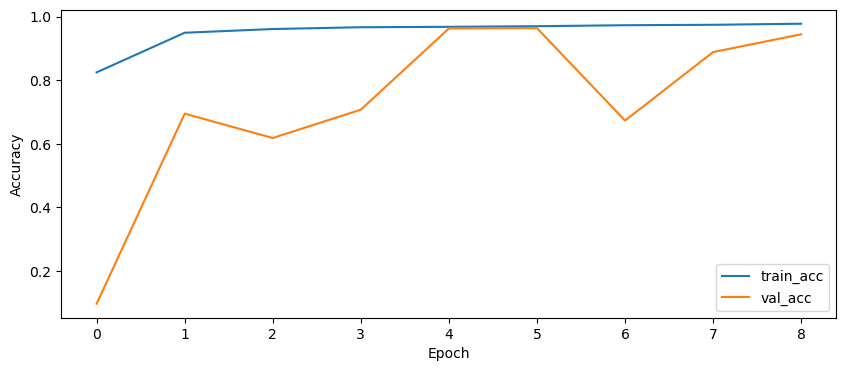

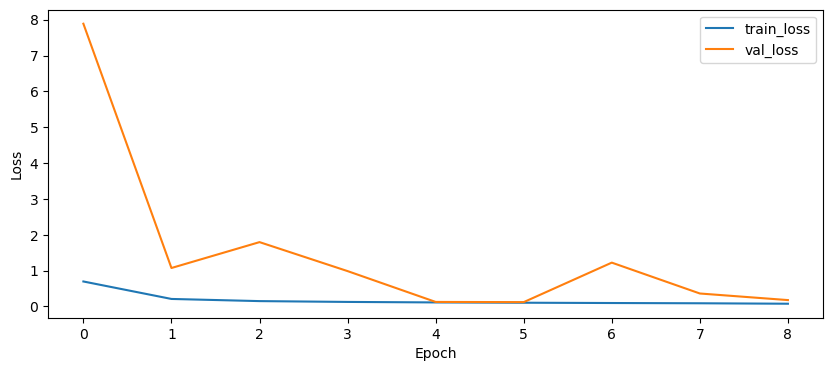

In [19]:
val_loss, val_acc = model.evaluate(val_ds, verbose=0)
print(f"Validation accuracy: {val_acc:.4f}")

plt.figure(figsize=(10, 4))
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [20]:
test_probs = model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
test_labels = np.argmax(test_probs, axis=1)

test_labels[:20]


array([2, 0, 9, 9, 3, 7, 0, 3, 0, 3, 5, 7, 4, 0, 4, 3, 3, 1, 9, 0])

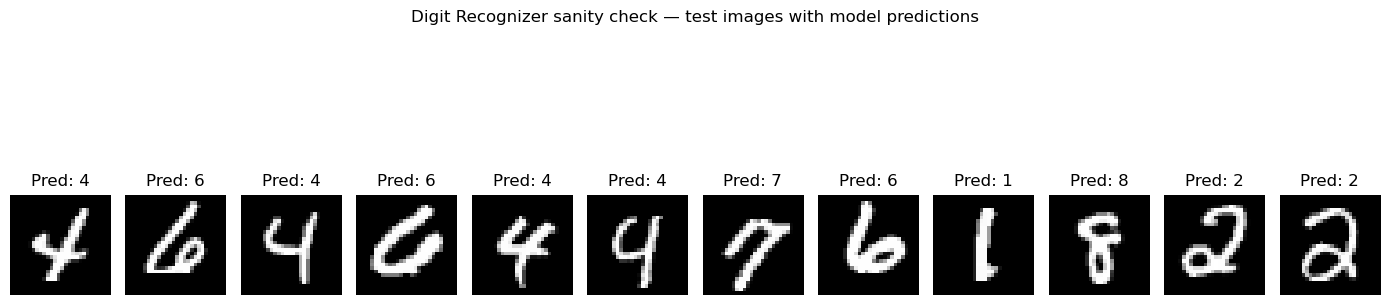

In [21]:
n_show = 12
idxs = np.random.choice(len(X_test), size=n_show, replace=False)

probs = model.predict(X_test[idxs], verbose=0)
preds = np.argmax(probs, axis=1)

plt.figure(figsize=(14, 4))
for i, idx in enumerate(idxs):
    ax = plt.subplot(1, n_show, i + 1)
    img = X_test[idx].reshape(28, 28)  # X_test is normalized; still fine for display
    ax.imshow(img, cmap="gray")
    ax.set_title(f"Pred: {preds[i]}")
    ax.axis("off")

plt.suptitle("Digit Recognizer sanity check — test images with model predictions", y=1.05)
plt.tight_layout()
plt.show()

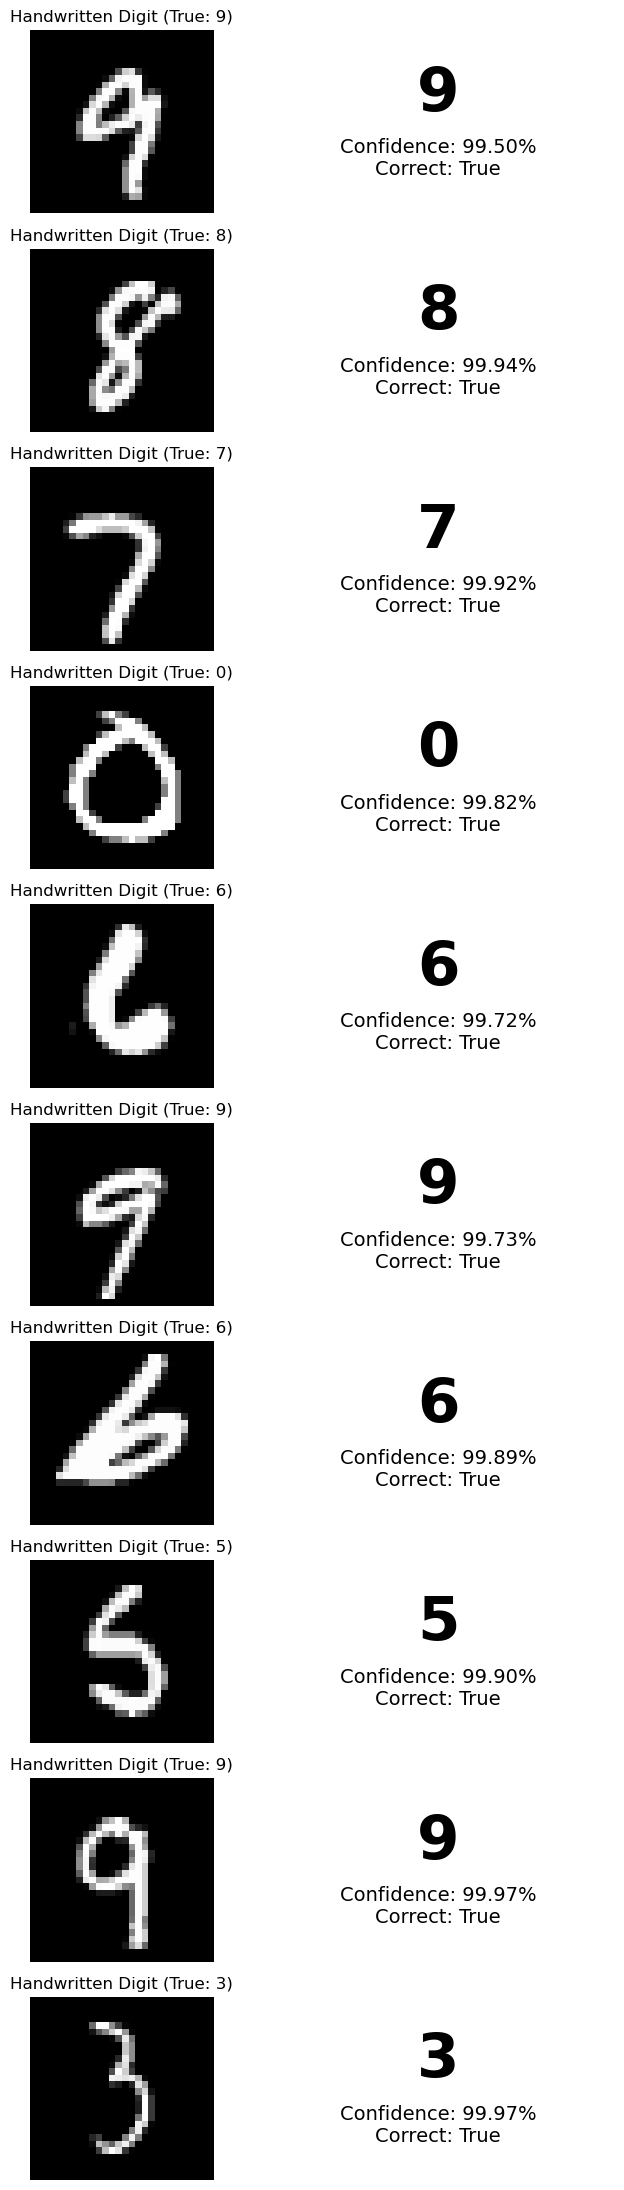

In [23]:
n = 10  
idx = np.random.choice(len(X_val), size=n, replace=False)

probs = model.predict(X_val[idx], verbose=0)
preds = np.argmax(probs, axis=1)
confs = np.max(probs, axis=1)


fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(7, 2.2 * n))

for row, (i, pred, conf) in enumerate(zip(idx, preds, confs)):
    img = X_val[i].squeeze()
    true = y_val[i]
    correct = (pred == true)
               
    ax_img = axes[row, 0]
    ax_img.imshow(img, cmap="gray")
    ax_img.axis("off")
    ax_img.set_title(f"Handwritten Digit (True: {true})")

    ax_txt = axes[row, 1]
    ax_txt.axis("off")
    ax_txt.text(
        0.5, 0.65,
        f"{pred}",
        ha="center", va="center",
        fontsize=44,
        fontweight="bold"
    )
    ax_txt.text(
        0.5, 0.30,
        f"Confidence: {conf:.2%}\nCorrect: {correct}",
        ha="center", va="center",
        fontsize=14
    )

plt.tight_layout()
plt.show()
